In [3]:
import numpy as np
import pandas as pd
from scipy import stats
from scipy import linalg
EPSILON = 1.1920929e-07
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import Parallel, delayed
import scanpy as sc
import pandas as pd
import spatialdm as sdm
import squidpy as sq
import tqdm
import adjustText
from scipy.optimize import minimize, minimize_scalar
from sklearn.neighbors import NearestNeighbors

In [4]:
import warnings
import networkx as nx

# Silencing FutureWarnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

The annotation is described here https://www.nature.com/articles/s41467-023-36062-6#MOESM1:~:text=For%20example%2C%20one,Fig.%C2%A04c and here https://academic.oup.com/nar/article/50/22/e131/6761985

In [5]:
import importlib

In [6]:
!pwd

/Users/hs0424/Workspace/copulacci/notebook/orator_paper_notebook


In [7]:
import sys
sys.path.append("/Users/hs0424/Workspace/copulacci/src/copulacci/")
import cci
import spatial
import model
import simulation

/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
import os

In [9]:
print("Loading spatial data")
adata = sc.read_visium('/Users/hs0424/Workspace/copulacci/data/3.Human_Breast_Cancer/')

Loading spatial data


In [10]:
adata.var_names_make_unique()

In [11]:
annotation_meta = pd.read_csv(
    '/Users/hs0424/Workspace/copulacci/data/3.Human_Breast_Cancer/metadata.tsv',
    sep = '\t',
    index_col=0
)

In [12]:
adata.obs = adata.obs.join(annotation_meta)

In [13]:
adata.raw = adata.copy()

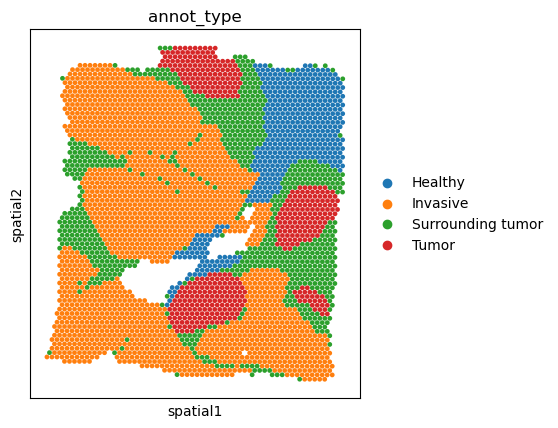

In [14]:
sc.pl.spatial(adata, color='annot_type', img_key=None,spot_size=260)

In [15]:
sdm.extract_lr(adata, 'human', min_cell=20)

In [16]:
adata_sdm = adata.copy()

In [49]:
# Same parameters as given in SDM tutorial
sdm.weight_matrix(adata_sdm, l=273, single_cell=False)

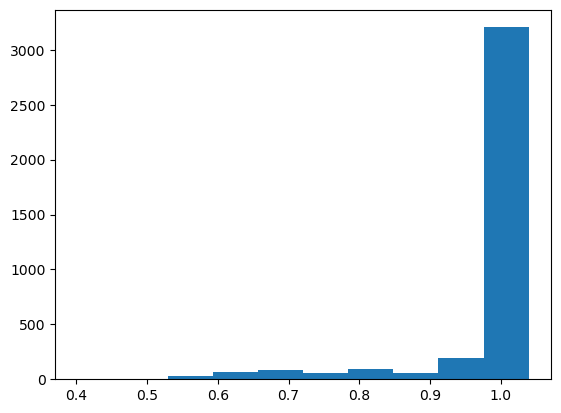

In [50]:
plt.hist(adata_sdm.obsp['weight'].toarray().sum(0));

In [23]:
importlib.reload(spatial)

<module 'spatial' from '/Users/hs0424/Workspace/copulacci/src/copulacci/spatial.py'>

In [24]:
G = nx.from_scipy_sparse_array(adata_sdm.obsp['nearest_neighbors'])

In [25]:
type(adata_sdm.obsp['weight'])

scipy.sparse._csr.csr_matrix

In [27]:
adata.obs['celltype'] = adata.obs.annot_type
int_edges_new, int_edges_with_selfloop = spatial.construct_boundary(
    adata, 
    G = G,
    weight_mat=adata_sdm.obsp['weight']
)

relabeling nodes


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14032/14032 [00:04<00:00, 2914.49it/s]


In [28]:
int_edges_new.head()

,cell1,cell2,celltype1,celltype2,distance,boundary_type,interaction
0,AAACAAGTATCTCCCA-1,AAACAAGTATCTCCCA-1,Surrounding tumor,Surrounding tumor,0.143924,Internal,Surrounding tumor=Surrounding tumor
1,AAACAAGTATCTCCCA-1,ACTAGTTGCGATCGTC-1,Surrounding tumor,Surrounding tumor,0.087294,Internal,Surrounding tumor=Surrounding tumor
2,ACTAGTTGCGATCGTC-1,AAACAAGTATCTCCCA-1,Surrounding tumor,Surrounding tumor,0.087294,Internal,Surrounding tumor=Surrounding tumor
3,AAACAAGTATCTCCCA-1,CAGCAGTCCAGACTAT-1,Surrounding tumor,Surrounding tumor,0.087294,Internal,Surrounding tumor=Surrounding tumor
4,CAGCAGTCCAGACTAT-1,AAACAAGTATCTCCCA-1,Surrounding tumor,Surrounding tumor,0.087294,Internal,Surrounding tumor=Surrounding tumor


In [30]:
df_lig_rec_linear = cci.extract_lig_rec_from_sdm(adata, allow_same_lr=True)
chosen_lr = list(set( df_lig_rec_linear.ligand.unique()).union(
    set( df_lig_rec_linear.receptor.unique() )
))
count_df = adata.raw.to_adata().to_df().loc[:,chosen_lr]

In [31]:
count_df.shape

(3798, 649)

In [34]:
adata

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'old_annot_type', 'old_fine_annot_type', '1', '2', '3', '4', '5', 'scaled_x', 'scaled_y', 'fine_annot', 'annot', 'fine_annot_type', 'ground_truth', 'annot_type', 'celltype'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'annot_type_colors', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter', 'spatial_network_names'
    obsm: 'spatial'

In [35]:
lig_list = adata.uns['ligand'].values
rec_list = adata.uns['receptor'].values

In [36]:
data_list_dict, umi_sums, dist_list_dict = spatial.prepare_data_list(
    count_df,
    int_edges_new,
    heteromeric=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization='sum'
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 16/16 [00:15<00:00,  1.00it/s]


In [37]:
importlib.reload(model)

<module 'model' from '/Users/hs0424/Workspace/copulacci/src/copulacci/model.py'>

In [38]:
dist_list_dict['Invasive=Invasive']

array([0.14392384, 0.08729422, 0.08729422, ..., 0.14392384, 0.14392384,
       0.14392384])

In [353]:
df_lig_rec = pd.concat(
   [ adata.uns['ligand'], adata.uns['receptor']],
    axis = 1
)

In [385]:
data_list_dict['Surrounding tumor=Surrounding tumor'][0]

(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [388]:
len(dist_list_dict['Surrounding tumor=Surrounding tumor'])

2227

In [380]:
print(
    len(data_list_dict['Surrounding tumor=Surrounding tumor'][0][0]),
    len(data_list_dict['Invasive=Invasive'][0][0])
)

2227 9656


In [381]:
print(len(umi_sums['Surrounding tumor=Surrounding tumor']))

1


In [384]:
len(umi_sums['Surrounding tumor=Surrounding tumor']['Surrounding tumor'])

2227

In [386]:
umi_sums['Surrounding tumor=Surrounding tumor']

{'Surrounding tumor': array([764., 593., 764., ..., 587., 292., 228.], dtype=float32)}

In [ ]:
umi

In [377]:
len(np.concatenate(
    [data_list_dict['Surrounding tumor=Surrounding tumor'][0][0],
    data_list_dict['Invasive=Invasive'][0][0]]
))

11883

In [372]:
data_list_dict['Invasive=Invasive'][0]

(array([0, 0, 2, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

In [480]:
importlib.reload(model)

<module 'model' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/model.py'>

In [40]:
df_lig_rec = pd.concat(
   [ adata.uns['ligand'], adata.uns['receptor']],
    axis = 1
)

In [41]:
cop_df_dict = model.run_copula(
    data_list_dict,
    umi_sums,
    dist_list_dict,
    DT=False,
    cutoff = 0.8,
    type_run='dense',
    num_restarts=1,
    df_lig_rec=df_lig_rec,
    heteronomic=True
)

Surrounding tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    6.3s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array 

Invasive=Invasive


[Parallel(n_jobs=20)]: Done 362 tasks      | elapsed:   21.2s
[Parallel(n_jobs=20)]: Done 630 tasks      | elapsed:   40.3s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:   56.0s remaining:    1.7s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:  1.0min finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: 

Healthy=Healthy


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.8s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    8.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.

Tumor=Tumor


/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))
[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    6.0s
[Parallel(n_jobs=20)]: Done 845 tasks      | elapsed:    9.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:   12.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Invasive=Surrounding tumor


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    4.5s
[Parallel(n_jobs=20)]: Done 1219 tasks      | elapsed:    6.1s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    6.2s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    6.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surrounding tumor=Invasive


[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    7.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Tumor=Invasive


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.9s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    5.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Invasive=Tumor


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    4.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Tumor=Surrounding tumor


[Parallel(n_jobs=20)]: Done 440 tasks      | elapsed:    2.8s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    6.5s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surrounding tumor=Tumor


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.7s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    5.1s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Healthy=Tumor


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    3.7s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    4.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Tumor=Healthy


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    3.1s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    4.3s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    4.6s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Healthy=Surrounding tumor


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    3.4s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Surrounding tumor=Healthy


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    3.9s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Healthy=Invasive


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.7s
[Parallel(n_jobs=20)]: Done 1235 tasks      | elapsed:    3.4s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    3.5s remaining:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    4.0s finished
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s


Invasive=Healthy


[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    2.5s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    3.7s finished


In [42]:
cop_df_dict = model.run_scc(
    count_df,
    None,
    cop_df_dict,
    int_edges_new,
    groups = list(data_list_dict.keys()),
    heteronomic=True,
    lig_list=lig_list,
    rec_list = rec_list,
    summarization = "sum"
)

Surrounding tumor=Surrounding tumor
Graph with 421 nodes and 1330 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    5.8s
[Parallel(n_jobs=20)]: Done 305 tasks      | elapsed:    7.8s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copula

Invasive=Invasive
Graph with 1634 nodes and 5651 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:   11.3s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:   18.2s remaining:    0.6s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:   18.7s finished


Healthy=Healthy
Graph with 355 nodes and 1219 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered i

Tumor=Tumor
Graph with 331 nodes and 1106 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.9s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    2.1s finished


Invasive=Surrounding tumor
DiGraph with 603 nodes and 580 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    4.1s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    6.5s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    6.7s finished


Surrounding tumor=Invasive
DiGraph with 603 nodes and 580 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 280 tasks      | elapsed:    1.4s
[Parallel(n_jobs=20)]: Done 780 tasks      | elapsed:    3.9s
[Parallel(n_jobs=20)]: Done 1276 out of 1315 | elapsed:    6.4s remaining:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    6.6s finished


Tumor=Invasive
DiGraph with 32 nodes and 23 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
/Users/hs0424/Workspace/copulacci/src/copulacci/model.py:1397: RuntimeWarning: invalid value encountered in scalar divide
  SCC = (N/W) * (cv/v) / 2.0
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.2s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.3s finished


Invasive=Tumor
DiGraph with 32 nodes and 23 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.1s finished


Tumor=Surrounding tumor
DiGraph with 239 nodes and 222 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    1.1s finished


Surrounding tumor=Tumor
DiGraph with 239 nodes and 222 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.5s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    1.1s finished


Healthy=Tumor
DiGraph with 30 nodes and 26 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.2s finished


Tumor=Healthy
DiGraph with 30 nodes and 26 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.2s finished


Healthy=Surrounding tumor
DiGraph with 179 nodes and 158 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.7s finished


Surrounding tumor=Healthy
DiGraph with 179 nodes and 158 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.7s finished


Healthy=Invasive
DiGraph with 61 nodes and 51 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.2s finished


Invasive=Healthy
DiGraph with 61 nodes and 51 edges


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 600 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 1315 out of 1315 | elapsed:    0.2s finished


In [43]:
cop_df_dict.keys()

dict_keys(['Surrounding tumor=Surrounding tumor', 'Invasive=Invasive', 'Healthy=Healthy', 'Tumor=Tumor', 'Invasive=Surrounding tumor', 'Surrounding tumor=Invasive', 'Tumor=Invasive', 'Invasive=Tumor', 'Tumor=Surrounding tumor', 'Surrounding tumor=Tumor', 'Healthy=Tumor', 'Tumor=Healthy', 'Healthy=Surrounding tumor', 'Surrounding tumor=Healthy', 'Healthy=Invasive', 'Invasive=Healthy'])

In [481]:
tmp1 = cop_df_dict['Surrounding tumor=Surrounding tumor'].copy()
tmp2 = cop_df_dict['Invasive=Surrounding tumor'].copy()

In [490]:
stats.spearmanr(tmp2.loc[tmp2.copula_method != 'skip'].rho_zero, 
                tmp2.loc[tmp2.copula_method != 'skip'].scc)

SignificanceResult(statistic=0.4654256196101703, pvalue=2.972607161155064e-22)

In [491]:
importlib.reload(model)

<module 'model' from '/n/fs/ragr-research/users/hirak/Projects/copulacci/src/copulacci/model.py'>

In [45]:
importlib.reload(sdm)

<module 'spatialdm' from '/Users/hs0424/miniforge3/envs/py390/lib/python3.9/site-packages/spatialdm/__init__.py'>

In [46]:
sdm_df_dict = model.run_sdm(
    adata,
    int_edges_new,
    groups = list(cop_df_dict.keys()),
    nproc = 20,
    heteronomic=True
)

Surrounding tumor=Surrounding tumor
Graph with 421 nodes and 1330 edges
(421, 36601)


AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [363]:
tmp1 = tmp1.loc[tmp1.copula_method != 'skip']
tmp2 = tmp2.loc[tmp2.copula_method != 'skip']

In [450]:
tmp2.sort_values('rho_zero', ascending = False)

,rho_one,rho_zero,copula_method
WNT3_FZD1_LRP5,0.039901,0.394604,copula
WNT4_FZD10_LRP5,0.000000,0.372295,copula
ANGPTL2_TLR4,0.000000,0.352649,copula
INHABB_ACVR2B,0.003530,0.318472,copula
AMH_AMHR2_BMPR1A,0.000000,0.299333,copula
...,...,...,...
AMH_AMHR2_ACVR1,0.100000,-0.357499,copula
WNT3_FZD4_LRP5,0.100000,-0.421016,copula
WNT3_FZD8_LRP5,0.100000,-0.459510,copula
WNT3_FZD5_LRP5,0.100000,-0.491677,copula


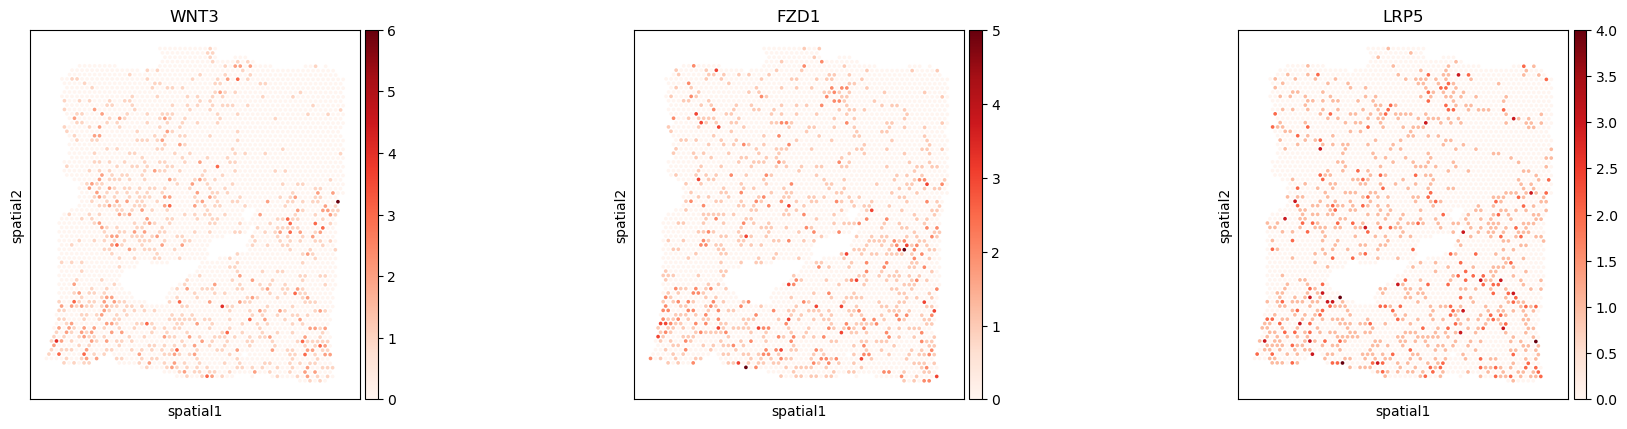

In [451]:
sc.pl.spatial(adata, img_key=None, color = ['WNT3',
                                           'FZD1',
                                           'LRP5'
                                          ],spot_size=200, cmap='Reds')

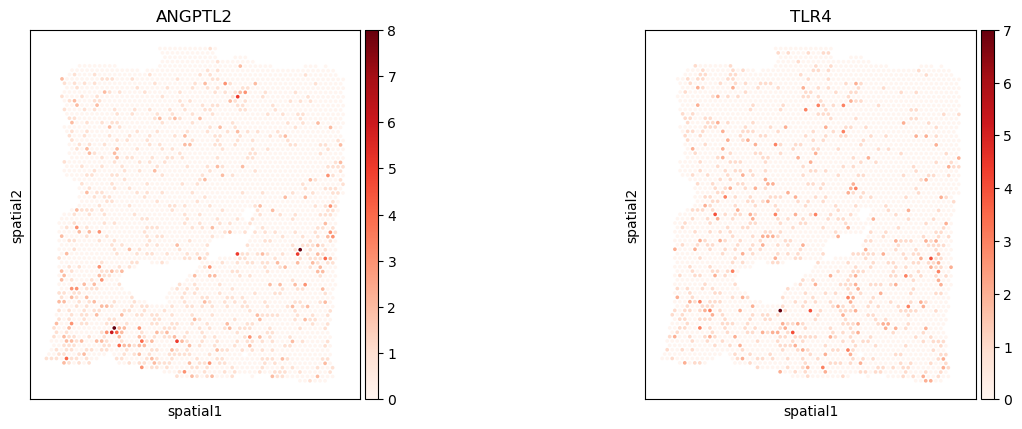

In [452]:
sc.pl.spatial(adata, img_key=None, color = ['ANGPTL2',
                                           'TLR4'
                                          ],spot_size=200, cmap='Reds')

In [228]:
# Same parameters as given in SDM tutorial
sdm.weight_matrix(adata_sdm, l=273,n_neighbors=6, single_cell=False)

In [229]:
m1 = np.array(adata_sdm.obsp['nearest_neighbors'].todense())
m2 = np.array(adata_sdm.obsp['weight'].todense())

(array([   5.,    6.,    0.,    0.,   91.,    0.,    0.,  139.,    0.,
        3557.]),
 array([0.67677934, 0.71002986, 0.74328037, 0.77653089, 0.8097814 ,
        0.84303192, 0.87628243, 0.90953294, 0.94278346, 0.97603397,
        1.00928449]),
 <BarContainer object of 10 artists>)

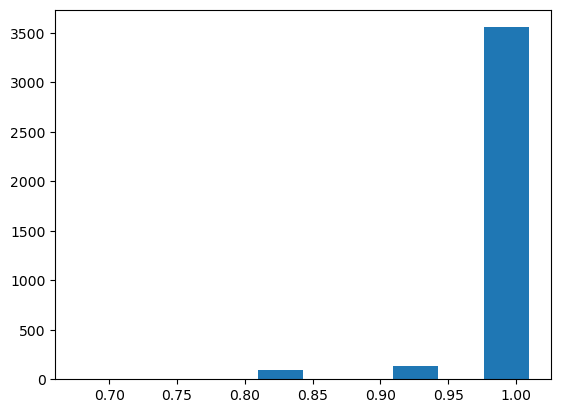

In [231]:
plt.hist(m1.sum(1))

In [207]:
G = nx.from_numpy_array(m1)

In [208]:
print(G)

Graph with 3798 nodes and 14009 edges


In [209]:
m1

array([[0.34112454, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.34112454, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.34112454, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.34112454, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.34112454,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.34112454]])

In [83]:
adata_sdm.obsp["nearest_neighbors"][0,397]

0.0

In [80]:
G.edges()

EdgeView([(0, 0), (0, 397), (0, 1087), (0, 2195), (0, 487), (0, 2425), (1, 1), (1, 588), (1, 2367), (1, 1773), (1, 3464), (1, 3165), (1, 1911), (2, 2), (2, 3749), (2, 2157), (2, 3105), (2, 3107), (2, 2321), (2, 1092), (3, 3), (3, 1438), (3, 1341), (3, 265), (3, 1451), (3, 3654), (3, 2077), (3, 2203), (3, 3710), (4, 4), (4, 1516), (4, 2171), (4, 3466), (4, 1169), (4, 2040), (5, 5), (5, 3315), (5, 3094), (5, 741), (5, 1390), (5, 1350), (6, 6), (6, 3300), (6, 1520), (6, 3723), (6, 2738), (6, 3737), (7, 7), (7, 1549), (7, 526), (7, 789), (7, 3758), (7, 2158), (7, 1519), (8, 8), (8, 653), (8, 1100), (8, 2454), (8, 922), (8, 2249), (9, 9), (9, 1233), (9, 616), (9, 3018), (9, 2530), (9, 3544), (9, 1317), (10, 10), (10, 1314), (10, 3399), (10, 3363), (10, 327), (10, 2147), (10, 1845), (11, 11), (11, 706), (11, 129), (11, 417), (11, 3600), (11, 131), (12, 12), (12, 1941), (12, 3621), (12, 1398), (12, 352), (12, 986), (13, 13), (13, 1511), (13, 1140), (13, 3580), (13, 2631), (13, 2686), (14, 14)